# Trying PyTorch for LSTM Encoder / Decoder
borrowed from interwebs
https://github.com/lkulowski/LSTM_encoder_decoder

## Standard header

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '-', '-', '-']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

In [2]:
#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

In [3]:
#import CoreFunctions as cf
from skimage.restoration import denoise_wavelet

## Choosing platfrom and folders

In [4]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

In [5]:
if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

In [6]:
if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/Recordings2/'
    imageFolder = '/sciclone/scr10/dchendrickson01/Move3Dprint/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

## Start Code

In [7]:
# Author: Laura Kulowski

'''
Example of using a LSTM encoder-decoder to model a synthetic time series 
https://github.com/lkulowski/LSTM_encoder_decoder

'''

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
import sys

import lstm_encoder_decoder
import plotting

matplotlib.rcParams.update({'font.size': 17})

In [34]:
import torch

In [8]:
def train_test_split(t, y, split = 0.8):

    '''
    
    split time series into train/test sets
    
    : param t:                      time array
    : para y:                       feature array
    : para split:                   percent of data to include in training set 
    : return t_train, y_train:      time/feature training and test sets;  
    :        t_test, y_test:        (shape: [# samples, 1])
    
    '''
    
    indx_split = int(split * len(y))
    indx_train = np.arange(0, indx_split)
    indx_test = np.arange(indx_split, len(y))

    t_train = t[indx_train]
    y_train = y[indx_train]
    y_train = y_train.reshape(-1, 1)
    
    t_test = t[indx_test]
    y_test = y[indx_test]
    y_test = y_test.reshape(-1, 1)
    
    return t_train, y_train, t_test, y_test 

In [9]:
def windowed_dataset(y, input_window = 5, output_window = 1, stride = 1, num_features = 1):
  
    '''
    create a windowed dataset
    
    : param y:                time series feature (array)
    : param input_window:     number of y samples to give model 
    : param output_window:    number of future y samples to predict  
    : param stide:            spacing between windows   
    : param num_features:     number of features (i.e., 1 for us, but we could have multiple features)
    : return X, Y:            arrays with correct dimensions for LSTM
    :                         (i.e., [input/output window size # examples, # features])
    '''
  
    L = y.shape[0]
    num_samples = (L - input_window - output_window) // stride + 1

    X = np.zeros([input_window, num_samples, num_features])
    Y = np.zeros([output_window, num_samples, num_features])    
    
    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            start_x = stride * ii
            end_x = start_x + input_window
            X[:, ii, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + input_window
            end_y = start_y + output_window 
            Y[:, ii, ff] = y[start_y:end_y, ff]

    return X, Y

In [10]:
def numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest):
    '''
    convert numpy array to PyTorch tensor
    
    : param Xtrain:                           windowed training input data (input window size, # examples, # features); np.array
    : param Ytrain:                           windowed training target data (output window size, # examples, # features); np.array
    : param Xtest:                            windowed test input data (input window size, # examples, # features); np.array
    : param Ytest:                            windowed test target data (output window size, # examples, # features); np.array
    : return X_train_torch, Y_train_torch,
    :        X_test_torch, Y_test_torch:      all input np.arrays converted to PyTorch tensors 

    '''
    
    X_train_torch = torch.from_numpy(Xtrain).type(torch.Tensor)
    Y_train_torch = torch.from_numpy(Ytrain).type(torch.Tensor)

    X_test_torch = torch.from_numpy(Xtest).type(torch.Tensor)
    Y_test_torch = torch.from_numpy(Ytest).type(torch.Tensor)
    
    return X_train_torch, Y_train_torch, X_test_torch, Y_test_torch

In [25]:
def SmoothMoves(file):
    #    if file[-3:] =='csv':
    ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0,invalid_raise=False)
    SmoothX = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    #SmoothY = denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    #SmoothZ = denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothX -= np.average(SmoothX)
    Time = []
    for r in ODataSet:
        hr = int(r[1]/10000)
        mint = int((r[1]-10000*hr)/100)
        sec = r[1] % 100
        t = hr * 3600 + mint * 60 + sec + r[2]/10000.0
        Time.append(t)
    #SmoothY -= np.average(SmoothY)
    #SmoothZ -= np.average(SmoothZ)
    #MoveMatrix = np.matrix([SmoothX, SmoothY, SmoothZ])
    return SmoothX, np.asarray(Time)

In [22]:
#----------------------------------------------------------------------------------------------------------------
# generate dataset for LSTM
y, t = SmoothMoves('230418 recording1.csv')

In [23]:
print(len(t), len(y))

#t=np.asarray(t)

18659125 18659125


In [30]:
t[-50:]

array([8.63997730e+04, 8.63997777e+04, 8.63997824e+04, 8.63997871e+04,
       8.63997918e+04, 8.63997965e+04, 8.63998012e+04, 8.63998059e+04,
       8.63998106e+04, 8.63998153e+04, 8.63998200e+04, 8.63998247e+04,
       8.63998294e+04, 8.63998341e+04, 8.63998388e+04, 8.63998435e+04,
       8.63998482e+04, 8.63998529e+04, 8.63998577e+04, 8.63998624e+04,
       8.63998671e+04, 8.63998718e+04, 8.63998765e+04, 8.63998812e+04,
       8.63998859e+04, 8.63998906e+04, 8.63998953e+04, 8.63999000e+04,
       8.63999048e+04, 8.63999095e+04, 8.63999142e+04, 8.63999189e+04,
       8.63999236e+04, 8.63999283e+04, 8.63999331e+04, 8.63999378e+04,
       8.63999425e+04, 8.63999472e+04, 8.63999519e+04, 8.63999566e+04,
       8.63999613e+04, 8.63999660e+04, 8.63999707e+04, 8.63999754e+04,
       8.63999802e+04, 8.63999849e+04, 8.63999896e+04, 8.63999943e+04,
       8.63999990e+04, 3.70000000e-03])

In [24]:
t_train, y_train, t_test, y_test = train_test_split(t, y, split = 0.8)

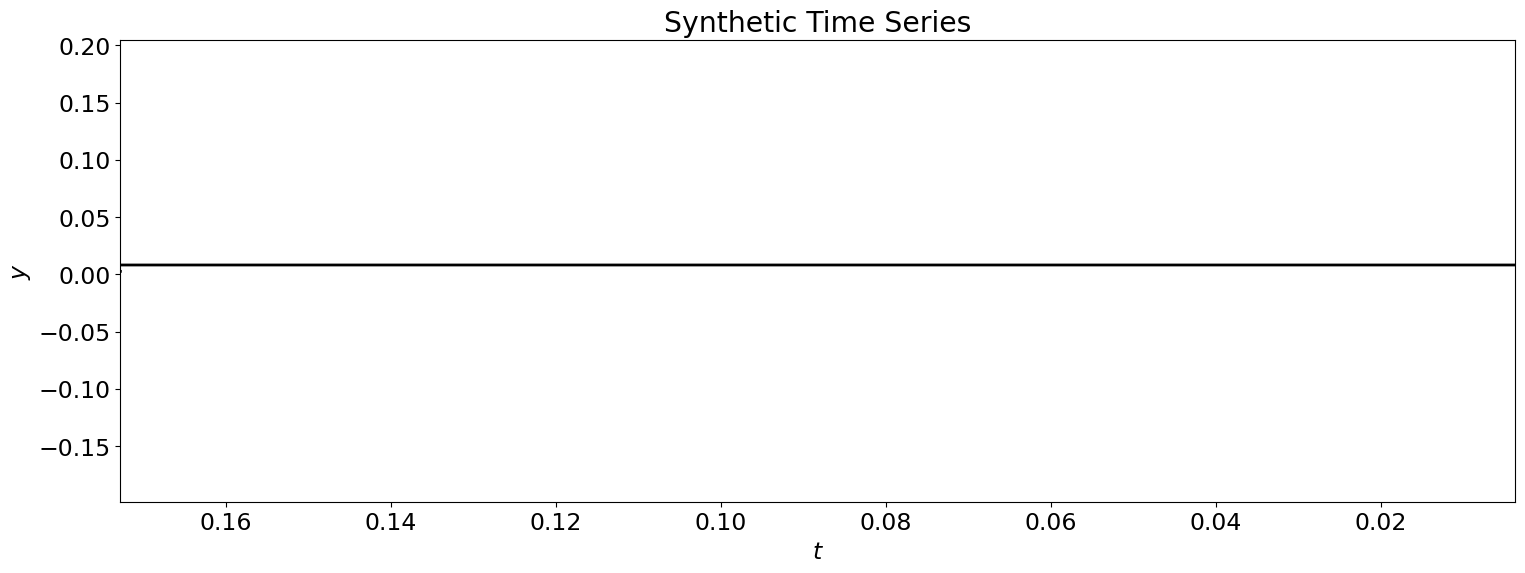

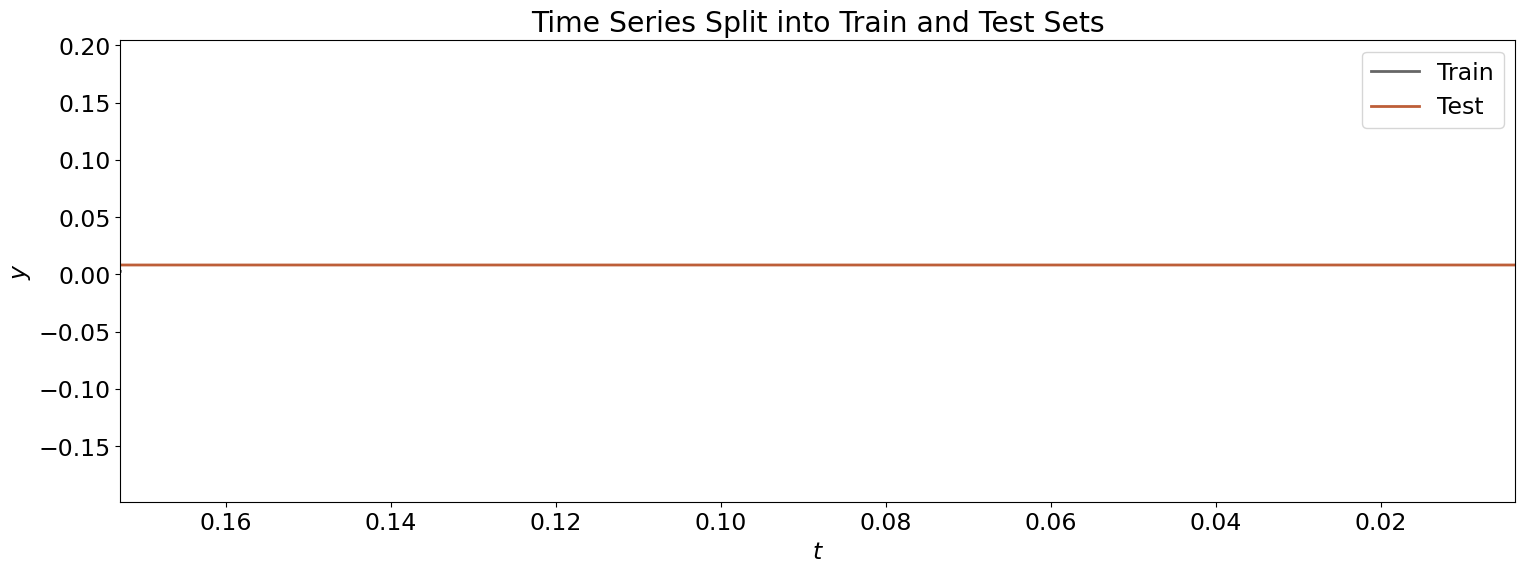

In [26]:
# plot time series 
plt.figure(figsize = (18, 6))
plt.plot(t, y, color = 'k', linewidth = 2)
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.title('Synthetic Time Series')
plt.savefig('plots/synthetic_time_series.png')

# plot time series with train/test split
plt.figure(figsize = (18, 6))
plt.plot(t_train, y_train, color = '0.4', linewidth = 2, label = 'Train') 
plt.plot(np.concatenate([[t_train[-1]], t_test]), np.concatenate([[y_train[-1]], y_test]),
         color = (0.74, 0.37, 0.22), linewidth = 2, label = 'Test')
plt.xlim([t[0], t[-1]])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Time Series Split into Train and Test Sets')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout
plt.savefig('plots/train_test_split.png')

In [31]:
#----------------------------------------------------------------------------------------------------------------
# window dataset

# set size of input/output windows 
iw = 80 
ow = 20 
s = 5

# generate windowed training/test datasets
Xtrain, Ytrain= windowed_dataset(y_train, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = windowed_dataset(y_test, input_window = iw, output_window = ow, stride = s)

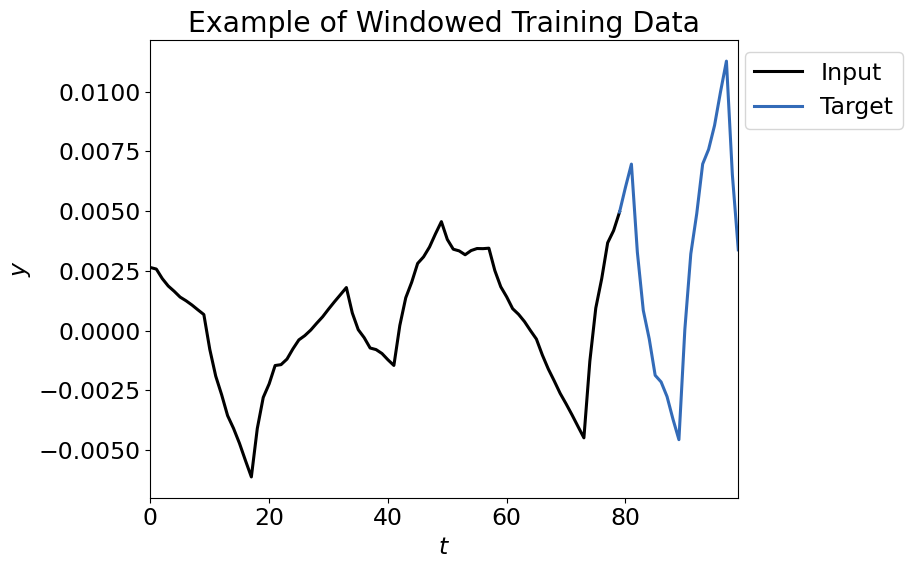

In [32]:
# plot example of windowed data  
plt.figure(figsize = (10, 6)) 
plt.plot(np.arange(0, iw), Xtrain[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, 0, 0]], Ytrain[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 
plt.savefig('plots/windowed_data.png')

In [35]:
#----------------------------------------------------------------------------------------------------------------
# LSTM encoder-decoder

# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

In [36]:
# specify model parameters and train
model = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 15)

In [ ]:
loss = model.train_model(X_train, Y_train, n_epochs = 50, target_len = ow, batch_size = 5, training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.6, learning_rate = 0.01, dynamic_tf = False)

  0%|                                                                                            | 0/50 [00:00<?, ?it/s]

In [ ]:
# plot predictions on train/test data
plotting.plot_train_test_results(model, Xtrain, Ytrain, Xtest, Ytest)

plt.close('all')

In [ ]:
model.save("PyTorch_LSTM_xyz")